<div style="direction: rtl;color: #4E4AE5;font-size: large;">
     <b>  Feature extraction
           استخراج ویژگی
</b>
<br/>
    توصيفگر ها نبايد نسبت به انتقال ، چرخش و تغيير مقياس حساس باشند

<br/>
    قطر مرز- نسبت ابعاد- تبدیل فوریه
<br/>
   
</div>

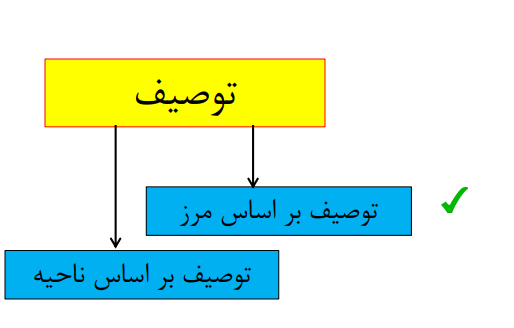

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

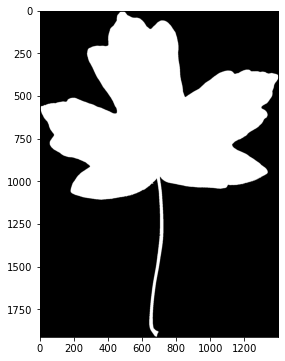

In [2]:
plt.figure(figsize=(10,6))
img= cv2.imread('images/thresholded/Acer_campestre_01.png',0)
plt.imshow(img, cmap='gray', vmin = 0, vmax = 255)


In [35]:
x,y,w,h = cv2.boundingRect(img)
aspect_ratio = float(w)/h
#---------------------------
print('aspect_ratio:',aspect_ratio)


aspect_ratio: 0.7306079664570231


<div style="direction: rtl;color: #4E4AE5;font-size: large;">
<b>  
       تبدیل فوریه    
</b>
<br/>
    1-کنتورهای تصویر را حساب می کنیم
<br/>
    برای نمایش کنتور، ابتدا یک تصویر سیاه به اندازه تصویر اصلی ایجاد می کنیم و کنتور را روی آن رسم می کنیم
<br/>
    2-آرایه سه بعدی کنتورها را به دو بعدی تبیدل میکنیم ؟؟
<br/>
    3-آرایه را به آرایه ای از اعداد موهومی تبدیل می کنیم
   <br/>
    4-ضرایب فوریه را محاسبه می کنیم
    <br/>
    5-زیر مجموعه ای ضرایب فوریه را انتخاب می کنیم (کاهش ابعاد)
   <br/>
    6-عکس تبدیل فوریه را انجام می دهیم
     <br/>
     <br/>
    
</div>

image_size (1912, 1398)


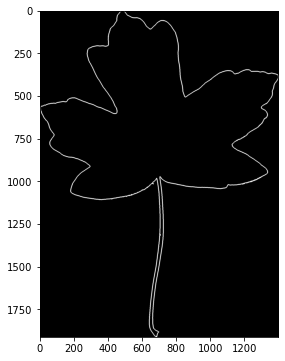

In [4]:
#ترسیم کنتور
contour = []
contour, hierarchy =cv2.findContours(img,1,2)
plt.figure(figsize=(10,6))
#ایجاد یک تصویر سیاه به اندازه تصویر اصلی
print("image_size", img.shape)
black = np.zeros((1912, 1398), np.uint8)
#ترسیم کنتور روی تصویر سیاه
cv2.drawContours(black, contour, -1, 255, thickness=4)
plt.imshow(black, cmap='gray', vmin = 0, vmax = 255)

3499


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


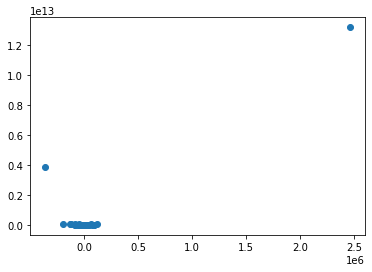

In [6]:
#تبدیل آرایه سه بعدی به دو بعدی
contour_array = contour[0][:, 0, :]

# تبدیل به عدد کمپلکس
contour_complex = np.empty(contour_array.shape[:-1], dtype=complex)
contour_complex.real = contour_array[:, 0]
contour_complex.imag = contour_array[:, 1]
# محاسبه سری فوریه
fourier_result = np.fft.fft(contour_complex)

#نمایش سری فوریه؟؟ نیازمند تکمیل و اصلاح
plt.scatter(fourier_result, fourier_result.real**2 + fourier_result.imag**2)
print(fourier_result.size)
#print(contour[0])
#print('-------------------')
#print(contour_array)
#print(contour_complex)

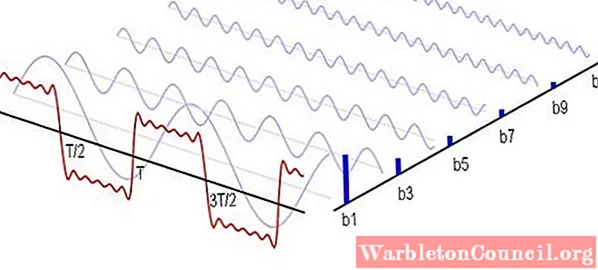

[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5 -5.  -4.5 -4.  -3.5
 -3.  -2.5 -2.  -1.5 -1.  -0.5]
[-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5
  2.   2.5  3.   3.5  4.   4.5]
10.0
[-1.  -0.5  0.   0.5]
[ 0.   0.5 -1.  -0.5]


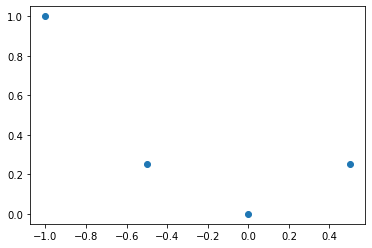

In [7]:
freqs = np.fft.fftfreq(20, 0.1)
print(freqs)
f1=np.fft.fftshift(freqs)
print(f1)
center_index = (len(f1)) / 2
print(center_index)
f1 = f1[int(center_index-4/2):int(center_index+4/2)]
print(f1)
f2=np.fft.ifftshift(f1)
print(f2)


plt.scatter(f2, f2.real**2 + f2.imag**2)
plt.show()

- به همه ضرایب فوریه نیاز نداریم و بخشی از آن ها را انتخاب می کنیم
کاهش سری فوریه

(3499,)
1749.0
(500,)


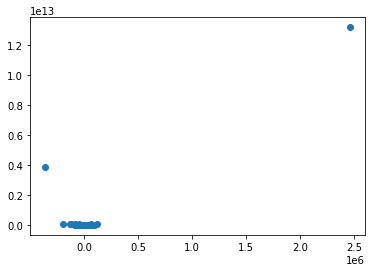

In [8]:
MIN_DESCRIPTOR = 500
descriptors = np.fft.fftshift(fourier_result)
print(fourier_result.shape)
center_index = (len(descriptors)-1) / 2
print(center_index)
descriptors = descriptors[int(center_index-MIN_DESCRIPTOR/2):int(center_index+MIN_DESCRIPTOR/2)]
plt.scatter(descriptors, descriptors.real**2 + descriptors.imag**2)
descriptors = np.fft.ifftshift(descriptors)
print(descriptors.shape)


اکنون عکس تبدیل فوریه را انجام می دهیم

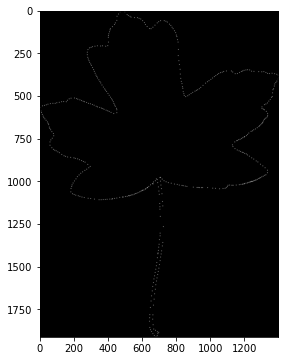

In [9]:
descriptors = np.fft.ifft(descriptors)
# بخش موهومی و حقیقی ضرایب فوریه را تفکیک می کنیم
contour_reconstruct = np.array( [descriptors.real, descriptors.imag])
contour_reconstruct = np.transpose(contour_reconstruct)
# ماتریس دو بعدی را مجددا به سه بعدی تبدیل می کنیم
contour_reconstruct = np.expand_dims(contour_reconstruct, axis=1)


# make positive
if contour_reconstruct.min() < 0:
        contour_reconstruct -= contour_reconstruct.min()
 # normalization
contour_reconstruct *= 1912 / contour_reconstruct.max()
contour_reconstruct = contour_reconstruct.astype(np.int32, copy=False)
# مجددا کنتور باز سازی شده را روی تصویر سیاه رسم می کنیم
cv2.drawContours(black, contour_reconstruct, -1, 255, thickness=4)
plt.figure(figsize=(10,6))
black1 = np.zeros((1912, 1398), np.uint8)
cv2.drawContours(black1, contour_reconstruct, -1, 255, thickness=4)
plt.imshow(black1, cmap='gray', vmin = 0, vmax = 255)